In [1]:
import requests
import pandas as pd

import datetime

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import yfinance as yf
import pandas_datareader as pdr

In [79]:
ticker = 'AAPL'
headers = {'User-Agent': 'Mozilla/5.0'}

start_date = datetime.datetime(2017, 9, 1)
end_date = datetime.datetime(2023, 9, 1)
TenYearBond = yf.download('^TNX', start_date, end_date).reindex(pd.date_range(start_date, end_date)).interpolate(method='nearest')
stock = yf.download(ticker, start_date, end_date).reindex(pd.date_range(start_date, end_date)).interpolate(method='nearest')

tickersResponse = requests.get('https://www.sec.gov/files/company_tickers.json', headers=headers)
tickers = pd.DataFrame.from_dict(tickersResponse.json(), orient='index')
cik = str(tickers[tickers['ticker'] == ticker]['cik_str'][0]).zfill(10)

factsResponse = requests.get('https://data.sec.gov/api/xbrl/companyfacts/CIK' + cik + '.json', headers=headers)
concepts = []
for col1 in factsResponse.json()['facts'].keys():
    for col2 in factsResponse.json()['facts'][col1].keys():
        concept = '/' + col1 + '/' + col2 + '.json'
        concepts.append(concept)

conceptResponse = requests.get('https://data.sec.gov/api/xbrl/companyconcept/CIK' + cik + concepts[282], headers=headers)
CashOperExp = pd.DataFrame.from_dict(conceptResponse.json()['units']['USD'])
conceptResponse = requests.get('https://data.sec.gov/api/xbrl/companyconcept/CIK' + cik + concepts[361], headers=headers)
CapEx = pd.DataFrame.from_dict(conceptResponse.json()['units']['USD'])
conceptResponse = requests.get('https://data.sec.gov/api/xbrl/companyconcept/CIK' + cik + concepts[284], headers=headers)
NetInc = pd.DataFrame.from_dict(conceptResponse.json()['units']['USD'])
conceptResponse = requests.get('https://data.sec.gov/api/xbrl/companyconcept/CIK' + cik + concepts[0], headers=headers)
SharesOutstanding = pd.DataFrame.from_dict(conceptResponse.json()['units']['shares'])
conceptResponse = requests.get('https://data.sec.gov/api/xbrl/companyconcept/CIK' + cik + concepts[395], headers=headers)
Revenue = pd.DataFrame.from_dict(conceptResponse.json()['units']['USD'])
conceptResponse = requests.get('https://data.sec.gov/api/xbrl/companyconcept/CIK' + cik + concepts[240], headers=headers)
IntExp = pd.DataFrame.from_dict(conceptResponse.json()['units']['USD'])
conceptResponse = requests.get('https://data.sec.gov/api/xbrl/companyconcept/CIK' + cik + concepts[264], headers=headers)
ShortLongTermDebt = pd.DataFrame.from_dict(conceptResponse.json()['units']['USD'])
conceptResponse = requests.get('https://data.sec.gov/api/xbrl/companyconcept/CIK' + cik + concepts[272], headers=headers)
LongTermDebt = pd.DataFrame.from_dict(conceptResponse.json()['units']['USD'])
conceptResponse = requests.get('https://data.sec.gov/api/xbrl/companyconcept/CIK' + cik + concepts[148], headers=headers)
EffTaxRate = pd.DataFrame.from_dict(conceptResponse.json()['units']['pure'])

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [80]:
CashOperExp = CashOperExp[CashOperExp['frame'].str.len() == 6.0]
CapEx = CapEx[CapEx['frame'].str.len() == 6.0]
NetInc = NetInc[NetInc['frame'].str.len() == 6.0]
SharesOutstanding = SharesOutstanding[SharesOutstanding['frame'].str[-2] == '4']
Revenue = Revenue[Revenue['frame'].str.len() == 6.0]
IntExp = IntExp[IntExp['frame'].str.len() == 6.0]
ShortLongTermDebt = ShortLongTermDebt[ShortLongTermDebt['frame'].str[-2] == '3']
LongTermDebt = LongTermDebt[LongTermDebt['frame'].str[-2] == '3']
EffTaxRate = EffTaxRate[EffTaxRate['frame'].str.len() == 6.0]

AvgRevInc = np.average((Revenue['val'] / Revenue.shift(1)['val'])[1:])

NetIncMargin = pd.merge(NetInc[['frame', 'val']], Revenue[['frame', 'val']], on='frame')
AvgNetIncMar = np.average(NetIncMargin['val_x'] / NetIncMargin['val_y'])

FreeCashFlow = pd.merge(CashOperExp[['frame', 'val']], CapEx[['frame', 'val']], on='frame')
FreeCashFlow['val_z'] = FreeCashFlow['val_x'] - FreeCashFlow['val_y']
FreeNetRatio = pd.merge(FreeCashFlow[['frame', 'val_z']], NetInc[['frame', 'val']], on='frame')
AvgFreeNet = np.average(FreeNetRatio['val_z'] / FreeNetRatio['val'])

In [81]:
def DCF(year):
    def valByYear(df, year):
        return df[df['frame'].str.contains(str(year))]['val'].iloc[0]

    #Calculate WACC
    DebtRate = (valByYear(IntExp, year) / (valByYear(ShortLongTermDebt, year) + valByYear(LongTermDebt, year))) * (1 - valByYear(EffTaxRate, year))

    Beta = 0.89
    ExpMarkReturn = 0.1
    CAPM = (TenYearBond.loc[pd.Timestamp(year, 9, 28)]['Close'] / 100) * (1 - Beta) + Beta * ExpMarkReturn

    TotalDebt = valByYear(ShortLongTermDebt, year) + valByYear(LongTermDebt, year)
    MarketCap = stock.loc[pd.Timestamp(year, 9, 28)]['Close'] * SharesOutstanding['val'].iloc[-1]

    WACC = TotalDebt / (TotalDebt + MarketCap) * DebtRate + MarketCap / (TotalDebt + MarketCap) * CAPM

    #Add discounted years
    todaysValue = 0
    forcastto = 4
    terminalGrowthRate = 0.025
    for forcastyear in range(1, forcastto + 1):
        todaysValue += valByYear(Revenue, year) * (AvgRevInc ** forcastyear) * AvgNetIncMar * AvgFreeNet / ((1 + WACC) ** forcastyear)
    #Add terminal value
    todaysValue += valByYear(Revenue, year) * (AvgRevInc ** forcastto) * AvgNetIncMar * AvgFreeNet * (1 + terminalGrowthRate) / (WACC + terminalGrowthRate) / ((1 + WACC) ** forcastto)

    #Unadjusted
    #return todaysValue / valByYear(SharesOutstanding, year)
    #Adjusted
    return todaysValue / SharesOutstanding['val'].iloc[-1]

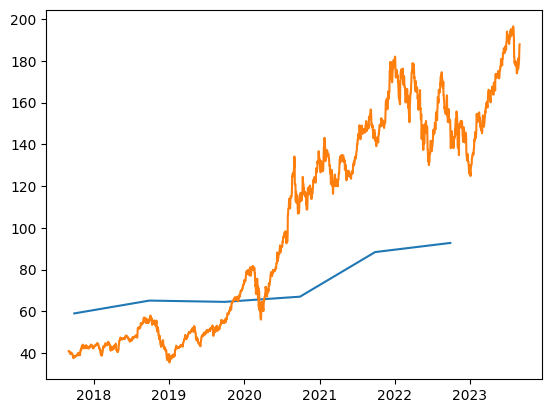

In [82]:
DCFs = []
X = []

for i in range(2017, 2023):
    DCFs.append(DCF(i))
    X.append(pd.to_datetime(str(i) + '-09-28'))

plt.plot(X, DCFs)
plt.plot(stock['Close'])
plt.show()